# Phasor Analysis for Fluroescence Decay

In [2]:
from TCSPC import *
plt.rcParams['figure.constrained_layout.use'] = True

### Create instances of Phasor class objects

In [3]:
NADH     = Phasor([0.75,0.25],[0.4,4])         #sim object
EGFP     = Phasor([0.497,0.503],[2.43,3.07])   #EGFP object
mCherry  = Phasor([0.83,0.17],[1.43,2.38]) #mCherry object
sim_list = [NADH,EGFP,mCherry]
sim_name = ['NADH','EGFP','mCherry']
for i in range(3):
    sim_list[i].name = sim_name[i] #add name attributes to objects


### Effect of noise on deviation from true phasor position

There is an intrinsic systematic error caused by finite period of the signal, while points on universal circle assumed infinite period.\
Update (27 Feb 2024): FFT of pure decay would be used in the system of equations for solving amplitudes and lifetime
- The systematic errors are displayed by horizontal line (distance of FFT phasor from analytic phasor position)
- As Signal to Noise ratio (SNR) increases ($SNR = \sqrt{N}$) with total number of photons $N$, FFT of noisy decay converges to the FFT of pure decay
- Background needs to be removed before comparison with FFT of pure decay as background would introduce a systematic offset

Update (7  March 2024): CHOICE OF HARMONICS used is very very important
- x coordinate of phasor position is used in blind decomposition of phasor
- when 1st-3rd harmonics are used, the results are very accurate and precise
- when 2nd-4th harmonics are used, results are unstable, inaccurate and imprecise


In [4]:
sim = EGFP
sim.phasor_true = multi_exp_FT(sim.w,sim.amp,sim.tau) #analytic phasor
n_photon_arr = np.logspace(4,9,20).astype(int)
def repeat_sim_n(sim,n_photon_arr = np.logspace(4,9,20).astype(int),n_repeat = 100):
    '''Store results of simulations for Simulation object sim 
    of n_photon in n_photon_arr (default  np.logspace(6,10,100).astype(int))
    Input:
    sim            Simulation Object
    n_photon_arr   Number of photons (collected in total) array
    n_repeat       Number of repeats in simulation
    '''
    sim.y_list = np.zeros((len(n_photon_arr),n_repeat,380)) #array to store 100 simulations of time domain data for each n_photon
    sim.phasor_list = np.zeros((len(n_photon_arr),n_repeat,380),dtype = complex) #array to store phasors from simulations of different n_photon
    sim.phasor_bg_list = np.zeros((len(n_photon_arr),n_repeat,380),dtype = complex) #with background
    for i in range(len(n_photon_arr)):
        sim.n_photon = n_photon_arr[i] #set n_photon
        sim.repeat_sim(n_repeat) #generate 100 simulations
        sim.y_list[i] = sim.sim_data #store 100 decays
        sim.phasor_list[i] = sim.phasor_data #store 100 phasors
        w,sim.phasor_bg_list[i] = sim.phasor_fft(sim.sim_data) #phasor with backhround
    
repeat_sim_n(sim)

### Effect of background (noisy)

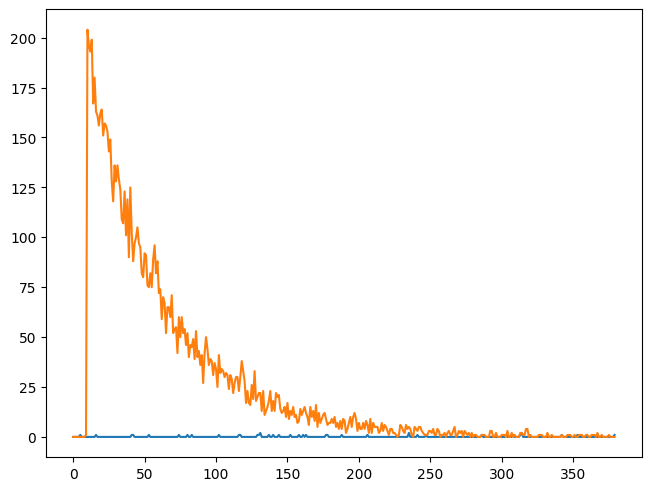

In [33]:
EGFP.n_photon=1e4
EGFP.multi_exp_data()
EGFP.phasor_fft()
pure_bg = np.ones(380)*EGFP.run_time*EGFP.bg/380
noisy_bg = rng.poisson(np.ones(380)*EGFP.run_time*EGFP.bg/380)
plt.plot(noisy_bg)
plt.plot(EGFP.y2)

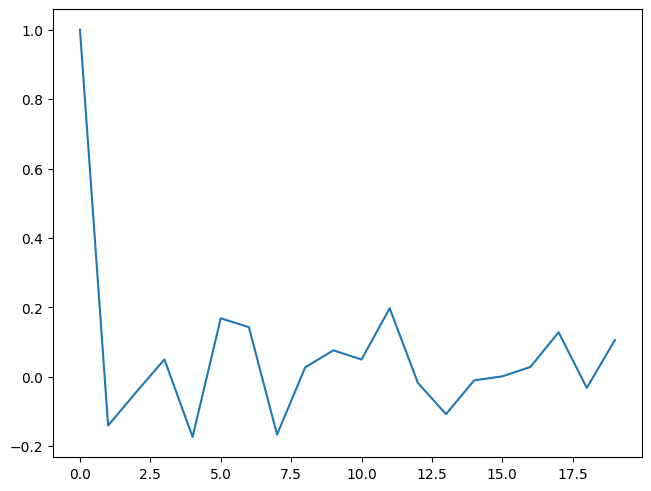

In [45]:
plt.plot((np.fft.fft(noisy_bg)/np.sum(noisy_bg))[:20])
#plt.plot(EGFP.phasor-EGFP.phasor_data[-1])
#plt.plot(np.fft.fft(EGFP.y2-noisy_bg)/np.sum(EGFP.y2))

Text(0.5, 1.0, 'Background not removed (FFT of Pure)')

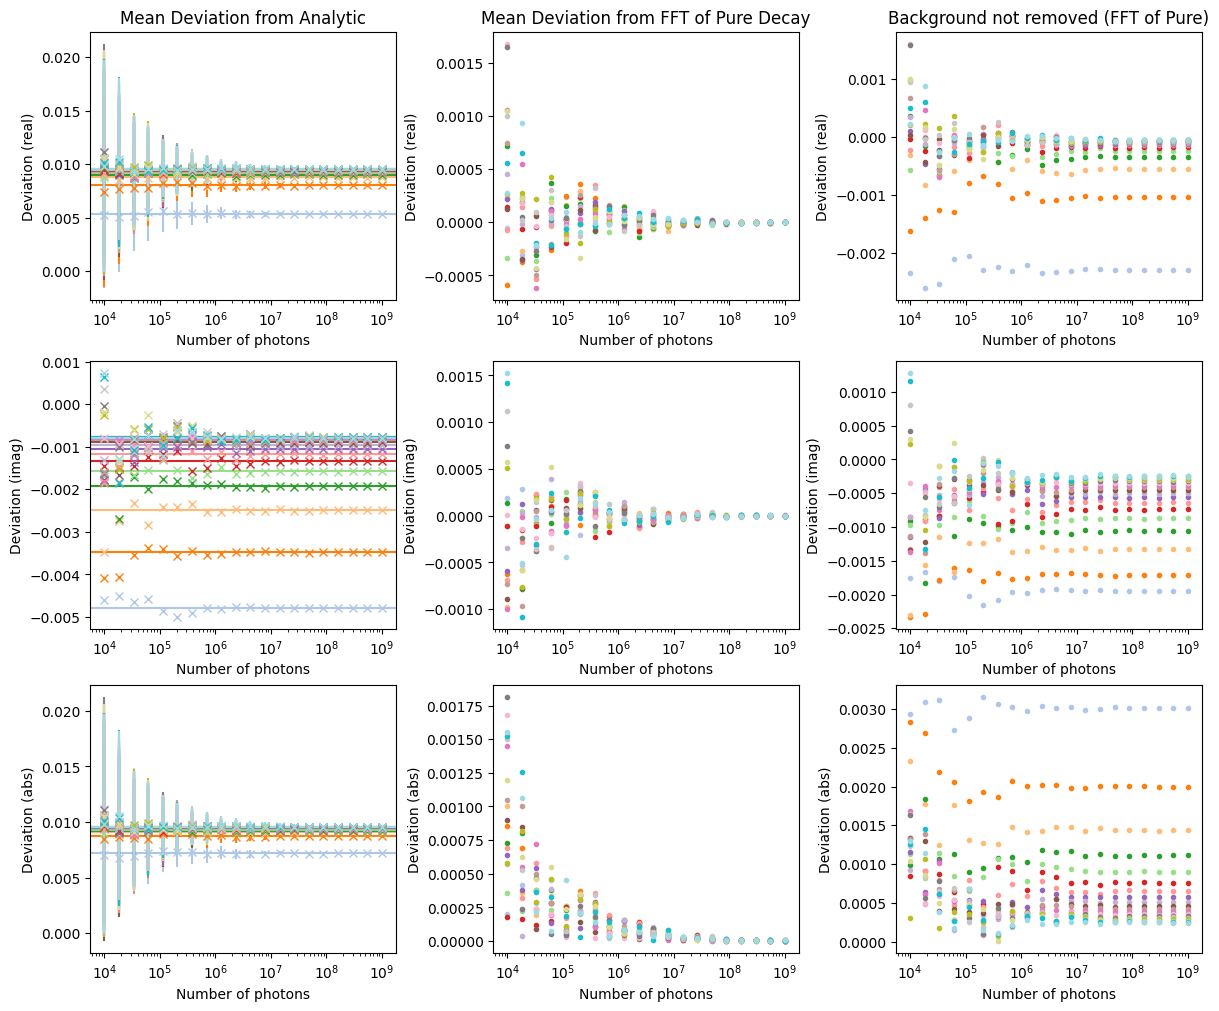

In [48]:
colors = cm.tab20(np.linspace(0,1,20)) #matplotlib color map
n = 10
sim.y_pure = exp2(sim.t,sim.amp[0],*sim.tau)
sim.y_pure = np.convolve(sim.y_pure,sim.ker,'full')[:sim.n_bins]/np.sum(sim.ker) #convolve with IRF
w,sim.phasor_pure = phasor_fft(sim.y_pure,sim.ker,sim.dt) 
fig,ax = plt.subplots(nrows = 3, ncols = 3,figsize = (12,10))
for j in range(3):
    fn = [np.real,np.imag,abs][j] #choose real, imag, abs values to plot
    name = ['real','imag','abs'][j]
    for n in range(1,20):
        ax[j,0].errorbar(n_photon_arr,fn(np.mean(sim.phasor_list,axis = 1)[:,n]-sim.phasor_true[n]),
                    yerr = fn(np.std(sim.phasor_list,axis = 1))[:,n],
                    fmt = 'x',color = colors[n],label=rf'$\omega_{n-1}$')
        ax[j,0].axhline(fn(sim.phasor_pure[n]-sim.phasor_true[n]),c=colors[n]) #deviation of FFT from analytic
        ax[j,1].plot(n_photon_arr,fn(np.mean(sim.phasor_list,axis = 1)[:,n]-sim.phasor_pure[n])
                ,'.',color = colors[n],label= rf'$\omega_{n-1}$')
        ax[j,2].plot(n_photon_arr,fn(np.mean(sim.phasor_bg_list,axis = 1)[:,n]-sim.phasor_pure[n])
                ,'.',color = colors[n],label= rf'$\omega_{n-1}$')
        for i in range(3):
            ax[j,i].set_xscale('log')
            ax[j,i].set_xlabel('Number of photons')
            ax[j,i].set_ylabel(f'Deviation ({name})')
            #ax[j,i].legend()
#plt.savefig('fig/phasor_no
ax[0,0].set_title('Mean Deviation from Analytic')
ax[0,1].set_title('Mean Deviation from FFT of Pure Decay')
ax[0,2].set_title('Background not removed (FFT of Pure)')



In [62]:
X.shape

(25, 20)

Text(0.5, 1.0, 'Background not removed (FFT of Pure)')

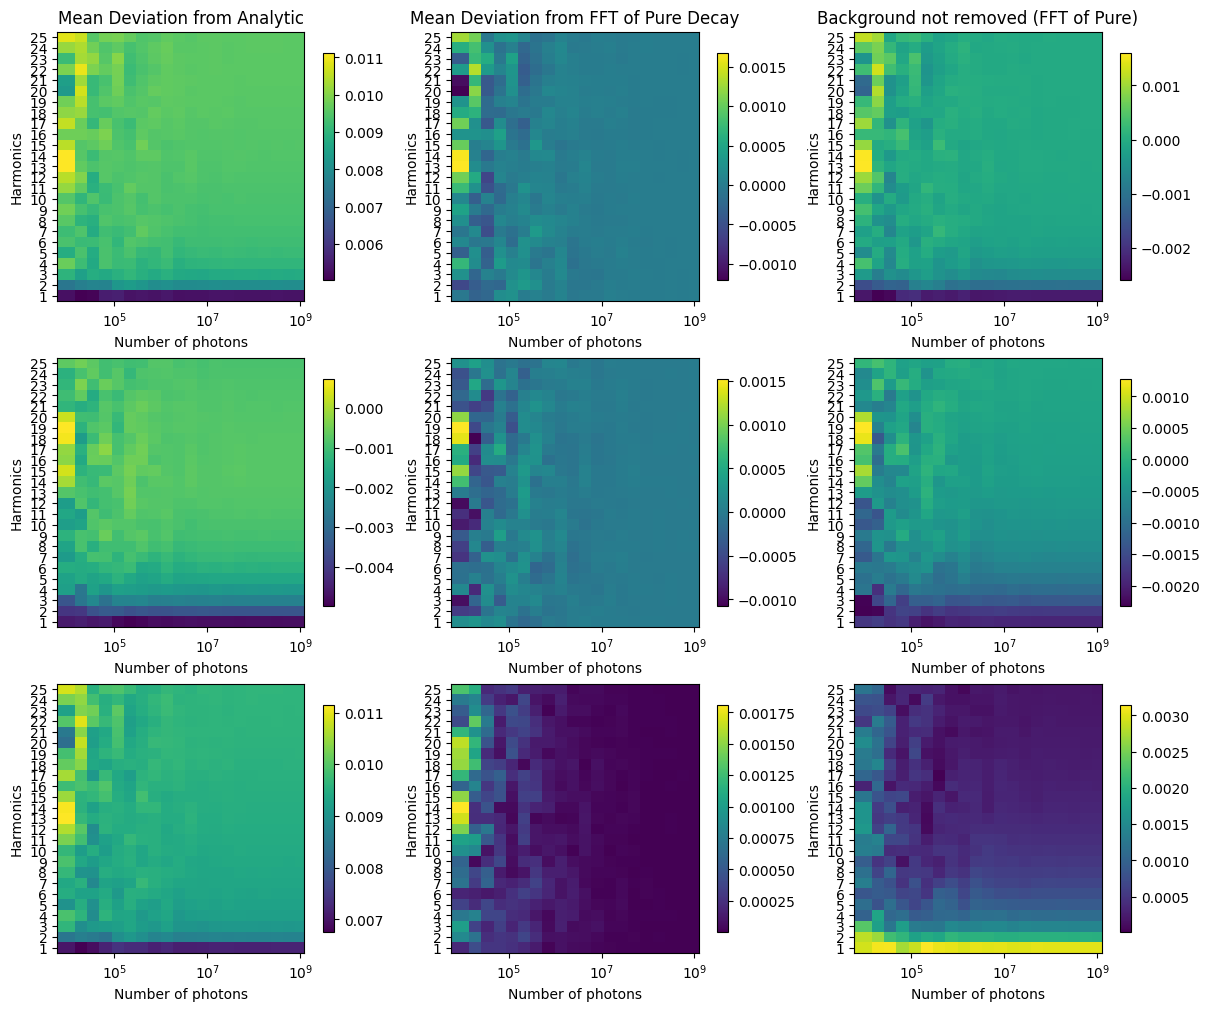

In [63]:
colors = cm.tab20(np.linspace(0,1,20)) #matplotlib color map
n = 10
sim.y_pure = exp2(sim.t,sim.amp[0],*sim.tau)
sim.y_pure = np.convolve(sim.y_pure,sim.ker,'full')[:sim.n_bins]/np.sum(sim.ker) #convolve with IRF
w,sim.phasor_pure = phasor_fft(sim.y_pure,sim.ker,sim.dt) 
fig,ax = plt.subplots(nrows = 3, ncols = 3,figsize = (12,10))
for j in range(3):
    fn = [np.real,np.imag,abs][j] #choose real, imag, abs values to plot
    name = ['real','imag','abs'][j]
    N_harmonics = 25
    harmonics = np.arange(1,N_harmonics+1,1) #nth harmonics
    X,Y = np.meshgrid(n_photon_arr,harmonics,indexing = 'ij')
    deviation_an = (np.mean(sim.phasor_list,axis = 1)-sim.phasor_true)[:,1:N_harmonics+1]
    deviation_no_bg = (np.mean(sim.phasor_list,axis = 1)-sim.phasor_pure)[:,1:N_harmonics+1]
    deviation_bg = (np.mean(sim.phasor_bg_list,axis = 1)-sim.phasor_pure)[:,1:N_harmonics+1]
    for i in range(3):
        cax = ax[j,i].pcolormesh(X,Y,fn([deviation_an,deviation_no_bg,deviation_bg][i]))
        ax[j,i].set_xscale('log')
        ax[j,i].set_xlabel('Number of photons')
        ax[j,i].set_ylabel('Harmonics')
        ax[j,i].set_yticks(harmonics)
        fig.colorbar(cax, ax=ax[j,i], fraction=0.046, pad=0.04)
            #ax[j,i].legend()
#plt.savefig('fig/phasor_no
ax[0,0].set_title('Mean Deviation from Analytic')
ax[0,1].set_title('Mean Deviation from FFT of Pure Decay')
ax[0,2].set_title('Background not removed (FFT of Pure)')


In [52]:
fig.savefig('fig/mean_deviation_phasor_harmonics.pdf')

In [6]:
[np.real,np.imag,abs][1](3)

0

Text(0.02, 0.5, 'S')

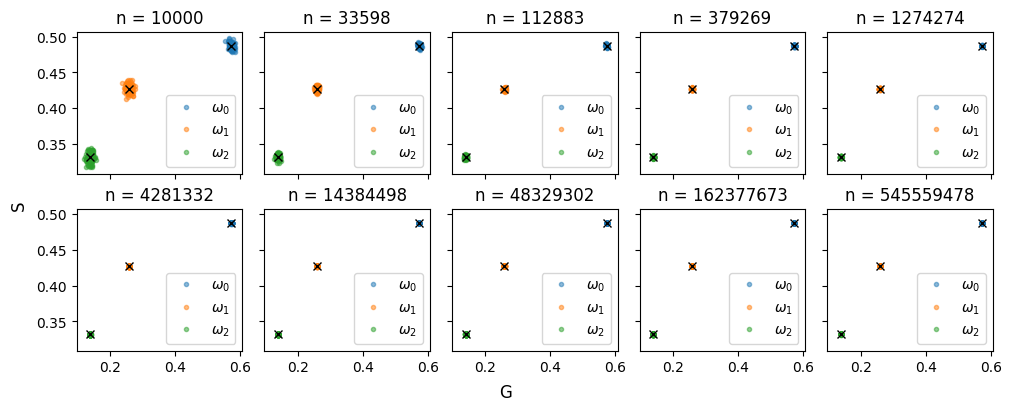

In [5]:
fig,ax = plt.subplots(nrows=2,ncols=5,figsize = (10,4),sharex=True,sharey=True)
ax = np.array(ax).flatten()
for i in range(10):
    ax[i].set_title(f'n = {n_photon_arr[i*2]}')
    for n in range(1,4):
        ax[i].plot(sim.phasor_list[2*i,:,n].real,sim.phasor_list[2*i,:,n].imag,'.',alpha =0.5,label = rf'$\omega_{n-1}$')
        #ax[i].plot(sim.phasor_bg_list[2*i,:,n].real,sim.phasor_bg_list[2*i,:,n].imag,'.',alpha =0.5,label = rf'bg,$\omega_{n-1}$')
        ax[i].plot(sim.phasor_pure.real[n],sim.phasor_pure.imag[n],'kx')
        ax[i].legend()
fig.supxlabel('G')
fig.supylabel('S')
#plt.savefig('fig/phasor_noise_scatter.pdf')


In [6]:
sim.n_photon = int(1e8)
sim.repeat_sim(100)
sim.generate_df() #generate df for 100 decays from phasor_data

,A1,tau1,tau2
0,0.497000,2.430819,3.068963
1,0.496833,2.432758,3.068581
2,0.496718,2.437069,3.064559
3,0.497235,2.425820,3.072373
4,0.497139,2.426283,3.072974
...,...,...,...
95,0.496953,2.431048,3.069257
96,0.496687,2.437812,3.063997
97,0.497002,2.429732,3.070315
98,0.496940,2.432051,3.068155


In [15]:
sim.generate_df(phasor_data=sim.phasor_bg_list[4])

/Users/chilaitang/Library/Mobile Documents/com~apple~CloudDocs/UCL PHY/Y3_Group_Project_2B/TCSPC-simulation/TCSPC.py:642: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  return fsolve(self.phasor_eq_func,x0=x0,args = phasor)


,A1,tau1,tau2
0,0.499315,2.335038,3.161373
1,0.489797,2.512216,3.055123
2,0.491160,2.505869,3.046303
3,0.490719,2.568443,2.972693
4,0.498367,2.345365,3.160037
...,...,...,...
95,0.487577,2.614690,2.953076
96,0.492048,2.506058,3.035093
97,0.495593,2.423746,3.095283
98,0.491869,2.471239,3.081284


In [17]:
fsolve(sim.phasor_eq_func_A_vary,x0 = [*sim.amp,*sim.tau],args = sim.phasor_data[3])

array([0.49703346, 0.50296654, 2.43004401, 3.06963189])

In [7]:
def hist_plot(sim, n_photon =None,method = 'powell',plot_phasor = True, plot_fit = True):
    '''Plot histograms of parameters obtained from repeated simulations
       Inputs:
       sim         Phasor object
       n_photon    total number of photons for simulation
       method      fit method
       plot_phasor/plot_fit Boolean variables to select parameters from which method to be plotted'''
    #set n_photon if it is provided
    if n_photon is None:
        pass
    else:
        sim.n_photon = n_photon
    sim.repeat_sim(100)
    if plot_fit == True:
        sim.repeat_sim_results(method = method)
    if plot_phasor ==True:
        sim.generate_df()

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4),constrained_layout = True)
    axes = np.array(axes).flatten()
    fig.suptitle(f'Total number of photons = {n_photon}')
    true_list = [sim.amp[0]]+sim.tau
    for i in range(3):
        # Plot the histogram on the corresponding axis
        col = ['A1','tau1','tau2'][i] #phasor.df column names
        axes[i].axvline(true_list[i].real,lw = 2,c = 'r',label = 'true')
        if plot_phasor == True:
            axes[i].hist(np.abs(np.real(sim.df.iloc[:,i])),label = 'Phasor',alpha = 0.5)
            axes[i].axvline(abs(np.mean(sim.df.iloc[:,i])),lw = 2,ls = '--',c='b',label = 'Phasor mean')
        if plot_fit == True:
            axes[i].hist(sim.val_df.iloc[:,i], bins=10,color = 'g',label = 'TCSPC',alpha = 0.3)  # Adjust the number of bins as needed
            axes[i].axvline(np.mean(sim.val_df.iloc[:,i]),lw = 2,c = 'k',ls=':',label = 'TCSPC mean')
        
        
        
        # Set the title and labels for the plot
        axes[i].set_title(f"Histogram of {col} ({sim.name})")
        axes[i].set_xlabel(col)

    
        axes[i].set_ylabel("Frequency")
        axes[i].legend()
    return fig,axes
#plt.savefig('fig/COBYLA_fit_phasor.pdf',format = 'pdf')

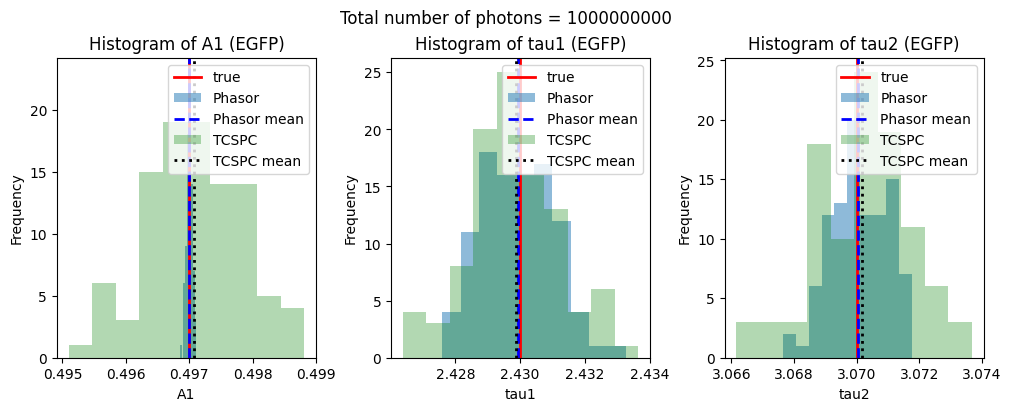

In [8]:
fig,ax = hist_plot(sim,n_photon = int(1e9),method = 'powell')

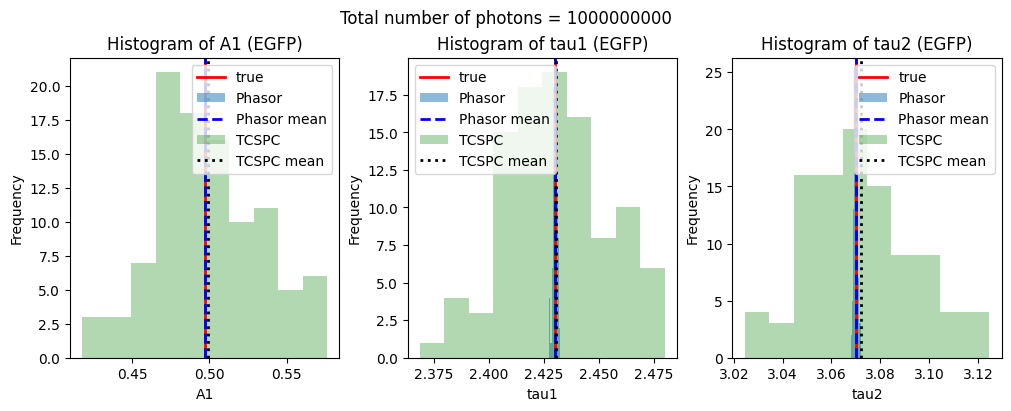

In [9]:
fig,ax = hist_plot(sim,n_photon = int(1e9),method = 'leastsq')

/Users/chilaitang/Library/Mobile Documents/com~apple~CloudDocs/UCL PHY/Y3_Group_Project_2B/TCSPC-simulation/TCSPC.py:642: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return fsolve(self.phasor_eq_func,x0=x0,args = phasor)


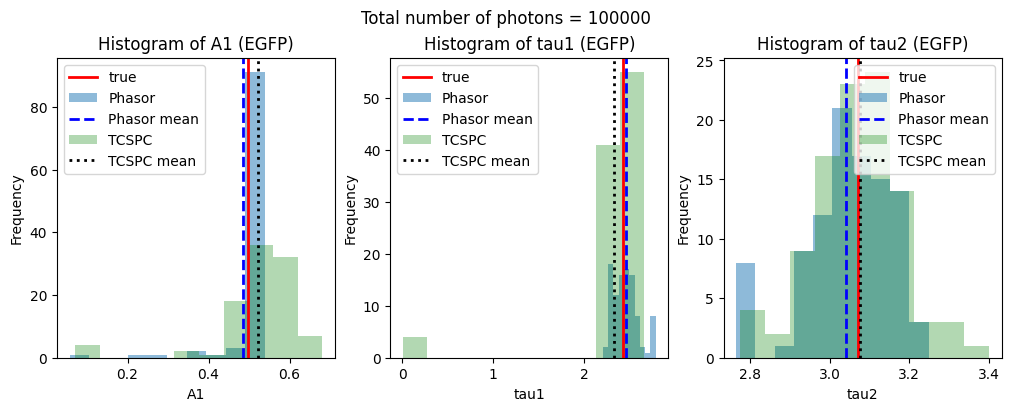

In [10]:
fig,ax = hist_plot(sim,n_photon = int(1e5),method = 'powell')

### Statistics of 100 simulations for each total photon count

At n_photon <200000, the numerical solver might raise RuntimeWarning

In [11]:
EGFP.n_photon = int(1e5)
EGFP.multi_exp_data() #generate decay
EGFP.phasor_fft()     #generate phasor
EGFP.phasor_solve_num()     #solve for A1, tau1, tau2 numerically

array([0.50178183, 2.31882644, 3.15137878])

### Perform fitting and phasor decomposition

# NO NEED TO RUN THESE CELLS AS THE RESULTS ARE GENERATED AND STORED IN 'TCSPC-simulation/df/' FOLDER AS CSV
# ONLY NEEDS TO READ THE CSV FILES AS `pd.DataFrame`

In [ ]:
# #store phasor df 
# df_list =[]
# #run this to detect the lower limit of repquired photons
# #warnings.filterwarnings("error", category=RuntimeWarning)
# for n_photon in n_photon_arr:
#     sim.n_photon = n_photon
#     sim.repeat_sim(100)
#     try:
#         sim.generate_df()
#     except:
#         print('n_photon lower limit: ', n_photon)
#     df_list.append(sim.df)
# #warnings.resetwarnings()

In [12]:
# store fit df
# this would take about 2mins to run
# no need to run this as the results are saved
i=0
val_df_list = []
info_df_list = []
par_df_list = []
for n_photon in n_photon_arr:
    sim.n_photon = n_photon
    sim.repeat_sim(100)
    sim.repeat_sim_results(method='powell',end=int(380*np.linspace(0.4,0.75,20)[i]))
    val_df_list.append(sim.val_df.droplevel(1))
    info_df_list.append(sim.info_df)
    par_df_list.append(sim.par_df)
    i+=1
    

In [65]:
# #concat df and uses multi index
# n_val_df = pd.concat(val_df_list,keys=range(20))
# n_phasor_df = pd.concat(df_list,keys=range(20)) 
# n_info_df = pd.concat(info_df_list,keys=range(20))
# n_par_df = pd.concat(par_df_list,keys=range(20))
# #save as csv
# n_val_df.to_csv('df/n_val_df.csv')
# n_phasor_df.to_csv('df/n_phasor_df.csv')
# n_par_df.to_csv('df/n_par_df.csv')
# n_info_df.to_csv('df/n_info_df.csv')


Read the csv of fitting/phasor results

In [69]:
#read multi index csv
n_val_df    = pd.read_csv('df/n_val_df.csv',index_col = [0,1]) 
n_phasor_df = pd.read_csv('df/n_phasor_df.csv',index_col = [0,1])
n_info_df   = pd.read_csv('df/n_info_df.csv',index_col = [0,1])
n_par_df    = pd.read_csv('df/n_par_df.csv',index_col = [0,1,2])

In [49]:
#concat 100 dfs of 100 repeated simulations for each photon number
mean_df = n_phasor_df.groupby(level=0).mean() #mean of each phasor_df
std_df  = n_phasor_df.groupby(level=0).std()#standard deviation of each phasor_df
mean_val_df = n_val_df.groupby(level=0).mean() #mean of each val_df
std_val_df  = n_val_df.groupby(level=0).std()#standard deviation of each val_df

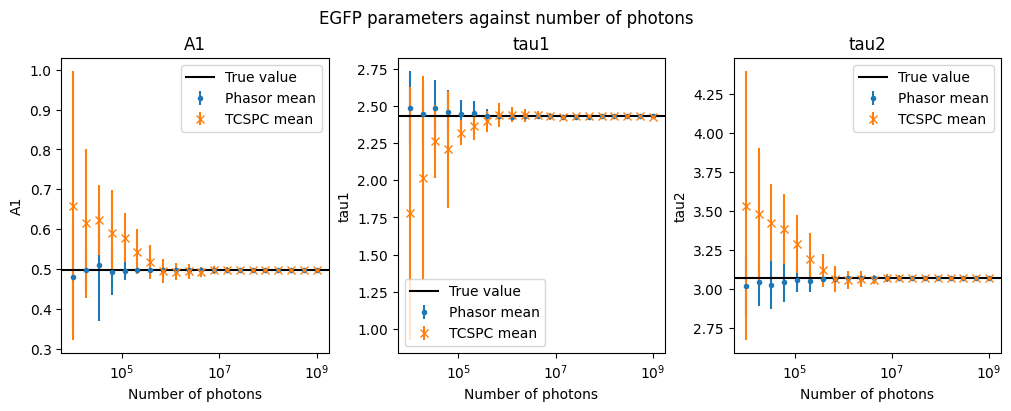

In [70]:
fig,ax = plt.subplots(nrows = 1,ncols = 3,figsize = (10,4))
ax =np.array(ax).flatten()
# repeat_sim_n(sim,n_photon_arr = np.logspace(5,10,125).astype(int)) 
# #only do this for phasor: fit method fails below 1e6 photons
# sim.generate_df(phasor_data=sim.phasor_list)
for i in range(3):
    ax[i].errorbar(n_photon_arr,abs(mean_df.iloc[:,i]),yerr = std_df.iloc[:,i],fmt = '.',label = 'Phasor mean')
    ax[i].errorbar(n_photon_arr,abs(mean_val_df.iloc[:,i]),yerr = std_val_df.iloc[:,i],fmt='x',label = 'TCSPC mean')
    true_list = [sim.amp[0]]+sim.tau
    ax[i].axhline(true_list[i],c='k',label = 'True value')
    ax[i].set_xlabel('Number of photons')
    ax[i].set_ylabel(sim.df.columns[i])
    ax[i].set_title(sim.df.columns[i])
    ax[i].legend()
    #ax[i].set_ylim(true_list[i]*0.95,true_list[i]*1.05)
    ax[i].set_xscale('log')
fig.suptitle(sim.name + ' parameters against number of photons')
#plt.savefig('fig/par_n_photons.pdf')

As discrete/fast Fourier trtansform of signal with finite period would deviate from universal circle (analytic Fourier transform of continupus, infinite period signal), phasor position of pure, noiseless fluorescence decay (convolved with IRF) obtained from fft is used. The method is the same as the one above that uses analytic phasor position, except that fft phasor is used. Numerical root solver is used to find the parameters that give a zero vector of length of `A_tau_arr` (A1,tau1,tau2).

In [29]:
from scipy.optimize import fsolve
def phasor_eq_func_A_vary(A_tau_arr,phasor):
    '''Function to be passed to phasor_solve_num to solve for A_tau array (A1,A2, tau1, tau2)
       Input: 
       A_tau_arr    parameter array A1,A2 tau1, tau2
       phasor       phasor array from Simulation().phasor to be resolved '''
    n = int(len(A_tau_arr)/2) #number of components
    y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n]) for j in range(n)]) #pure multiexponential
    y = np.convolve(y,EGFP.ker,'full')[:EGFP.n_bins]/np.sum(EGFP.ker)
    w,phasor_test = EGFP.phasor_fft(y=y) 
    A_sum = 1-np.sum(A_tau_arr[:n]) #A1,...An sum to 1
    phasor_compare = phasor_test.real[:2*n-1]-phasor.real[:2*n-1] #solve for A_tau_arr such that it gives 0
    return [A_sum]+list(phasor_compare) #

def phasor_eq_func(A_tau_arr,phasor):
    '''Function to be passed to phasor_solve_num to solve for A_tau array (A1, tau1, tau2) (2n-1)
       Input: 
       A_tau_arr    parameter array A1 tau1, tau2
       phasor       phasor array from Simulation().phasor to be resolved '''
    n = int((len(A_tau_arr)+1)/2) #number of components
    #A_tau_arr = np.insert(A_tau_arr,n-1,1-np.sum(A_tau_arr[:n-1])) #insert An
    y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
    y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
    y  = np.convolve(y,EGFP.ker,'full')[:EGFP.n_bins]/np.sum(EGFP.ker)
    w,phasor_test = EGFP.phasor_fft(y=y) 
    return phasor_test.real[:2*n-1]-phasor.real[:2*n-1] #solve for A_tau_arr such that it gives 0
    

def phasor_solve_num(phasor,x0):
    '''Solve for amplitude and lifetimes numerically using 3 phasors for 3 parameters (A1, tau1, tau2)
       phasor      phasor array (Simulation().phasor) to be resolved
       x0          initial guess for a_tau_arr'''
    return fsolve(phasor_eq_func,x0=x0,args = phasor)


In [36]:
sim.n_photon = int(1e9)
sim.repeat_sim(100)
phasor_solve_num(sim.phasor_data[7],x0=[1]) #mono exp guess

array([1.00000001])

In [46]:
phasor_solve_num(sim.phasor_data[7],x0=[2.8]) #mono exp guess

array([2.8])

In [41]:
phasor_solve_num(sim.phasor_data[7],x0=[0.495,2.43,3.07])

array([0.50018423, 2.43220548, 3.07195585])

In [42]:
phasor_solve_num(sim.phasor_data[7],x0=[0.3,0.2,2.4,3.07,1]) #3 exp guess (A1,A2,tau1,tau2,tau3) (2n-1)

array([0.48884557, 0.51304839, 2.41535453, 3.06787634, 0.99999996])

In [48]:
phasor_solve_num(sim.phasor_data[7],x0=[0.3,0.2,0.1,2.4,3.07,5,6])

/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_1595/1970126380.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return fsolve(phasor_eq_func,x0=x0,args = phasor)


array([0.3 , 0.2 , 0.1 , 2.4 , 3.07, 5.  , 6.  ])

In [51]:
p1 = Phasor([1],[2])

p1.phasor_solve_num(phasor = p1.phasor_data[9])

array([2.00000006])

In [53]:
p1.phasor_solve_num(phasor = p1.phasor_data[9],x0 = [0.4,1.8,2.5])

array([0.45669869, 1.94157107, 2.04731969])

### Separability in phasor

In [48]:
A_tau_arr =  [ 0.497,2.43,3.07]
n = 2
y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
A_tau_arr = np.insert(A_tau_arr,n-1,1-np.sum(A_tau_arr[:n-1])) #insert An
y2  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n]) for j in range(n)]) 
y = np.convolve(y,EGFP.ker,'full')[:EGFP.n_bins]/np.sum(EGFP.ker)
w,p = EGFP.phasor_fft(y=y)

In [50]:
from scipy.optimize import root,bisect
EGFP.n_photon = int(1e8)
EGFP.repeat_sim(100)
root(phasor_eq_func,x0 =[0.497]+[2.43,3.07],args =EGFP.phasor_data[8],method = 'hybr')

 message: The solution converged.
 success: True
  status: 1
     fun: [-2.220e-16 -1.430e-12 -1.087e-12]
       x: [ 4.971e-01  2.429e+00  3.071e+00]
  method: hybr
    nfev: 7
    fjac: [[-4.206e-07  7.852e-01  6.192e-01]
           [ 5.719e-06 -6.192e-01  7.852e-01]
           [-1.000e+00 -3.871e-06  4.230e-06]]
       r: [ 1.425e-01 -9.896e-02 -1.215e-01 -8.358e-03  7.805e-03
            1.005e-07]
     qtf: [ 5.820e-11 -6.652e-11 -1.828e-16]

In [19]:
phasor_eq_func([0.497]+[2.43,3.07],p)

array([0., 0., 0.])

In [51]:
sim = EGFP
sim.n_photon = int(1e8)
sim.repeat_sim(100)
phasor_solve_num(sim.phasor_data[1],[sim.amp[0],*sim.tau])

array([0.60968926, 2.49361835, 3.15582202])

In [46]:
sim.phasor_solve_num2(sim.phasor_data[16],[sim.amp[0],*sim.tau])

array([0.30911478, 2.27921637, 2.96167127])

In [43]:
phasor_solve_num(sim.phasor_data[1],[sim.amp[0],*sim.tau])

array([0.3750568 , 2.32900071, 3.00262244])

In [52]:
par = np.zeros((100,3))
for i in range(100):
    par[i] = phasor_solve_num(sim.phasor_data[i],[sim.amp[0],*sim.tau])

In [53]:
par

array([[0.49701809, 2.42977185, 3.07006469],
       [0.49705108, 2.42994232, 3.06944174],
       [0.49706969, 2.42816062, 3.07146264],
       [0.49692481, 2.43128949, 3.06929972],
       [0.49681727, 2.43382527, 3.06742267],
       [0.49692719, 2.43214503, 3.06818934],
       [0.49682288, 2.43345651, 3.06782144],
       [0.49719592, 2.42631959, 3.07222905],
       [0.4969905 , 2.42926745, 3.07104278],
       [0.49705033, 2.43078183, 3.06839038],
       [0.49693109, 2.43261964, 3.06754168],
       [0.49680136, 2.43441297, 3.06687873],
       [0.49710986, 2.42663167, 3.07289818],
       [0.49693492, 2.43041473, 3.07028018],
       [0.49691446, 2.43195354, 3.0685888 ],
       [0.49695821, 2.43278945, 3.06699198],
       [0.4971133 , 2.42706447, 3.07230888],
       [0.4970529 , 2.42833708, 3.0714473 ],
       [0.49696815, 2.43052954, 3.06972438],
       [0.4971882 , 2.42426013, 3.07492636],
       [0.49701205, 2.42770705, 3.0727479 ],
       [0.49683031, 2.43410243, 3.06691347],
       [0.

(array([ 2.,  0., 14., 17., 24., 21., 14.,  7.,  0.,  1.]),
 array([3.06255279, 3.06412151, 3.06569022, 3.06725894, 3.06882765,
        3.07039637, 3.07196508, 3.0735338 , 3.07510251, 3.07667123,
        3.07823994]),
 <BarContainer object of 10 artists>)

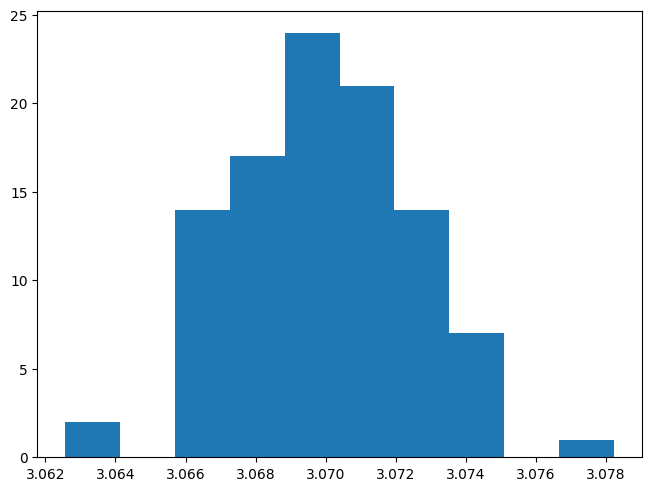

In [54]:
plt.hist(par[:,2])

In [56]:
sim.n_photon = int(1e4)
sim.repeat_sim(100)
np.std(par,axis = 0)

array([0.15251107, 0.09921497, 0.15120322])

In [57]:
np.mean(par,axis = 0)

array([0.50503289, 2.4211774 , 3.10316492])

In [255]:
mCherry.n_photon

2988000

### Example use of methods in Phasor class

| Method         | Description                                                                                           | Default Values                            |
|----------------|-------------------------------------------------------------------------------------------------------|-------------------------------------------|
| `phasor_solve()` | Solve for amplitudes and lifetime with  given w array (angular frequency) and phasor array            | w = self.w, phasor = self.phasor           |
| `generate_df()`  | Generate pd.DataFrame() to store phasor decomposition results for given w array and phasor_data array | w = self.w, phasor_data = self.phasor_data |

In [3]:
mCherry.phasor_solve()

array([ 0.32309665,  0.67690335, -2.16219325, -1.25143316])

Generated dataframe can be accessed by :

In [8]:
NADH.df

,A1,A2,t1,t2,0.05,0.1,0.15,0.2
0,0.773565,0.226435,0.383344,4.011066,0.533922+0.393668j,0.335185+0.311682j,0.267018+0.260961j,0.229114+0.234194j
1,0.777003,0.222997,0.373202,4.007152,0.533774+0.393932j,0.335108+0.311228j,0.267496+0.260462j,0.229023+0.234285j
2,0.778156,0.221844,0.368662,4.002895,0.533735+0.394038j,0.334913+0.311277j,0.267488+0.261125j,0.228707+0.234603j
3,0.771441,0.228559,0.394710,4.018032,0.534813+0.393424j,0.336426+0.311589j,0.267689+0.261362j,0.229945+0.234405j
4,0.771709,0.228291,0.390714,4.014340,0.534349+0.393716j,0.335696+0.311543j,0.267133+0.261381j,0.228674+0.234692j
...,...,...,...,...,...,...,...,...
95,0.772166,0.227834,0.391965,4.025342,0.533692+0.393483j,0.335588+0.311593j,0.267179+0.260729j,0.228943+0.234455j
96,0.771442,0.228558,0.392486,4.014181,0.534671+0.393421j,0.336041+0.311786j,0.267363+0.261045j,0.229700+0.234807j
97,0.774209,0.225791,0.386481,4.021848,0.533927+0.393383j,0.335876+0.311367j,0.267750+0.260935j,0.229456+0.234639j
98,0.773249,0.226751,0.386177,4.013742,0.534177+0.393443j,0.335612+0.311203j,0.267327+0.261289j,0.229281+0.234662j


/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_11628/2387067119.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pdf" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('fig/FT_compare.pdf',pdf = True)


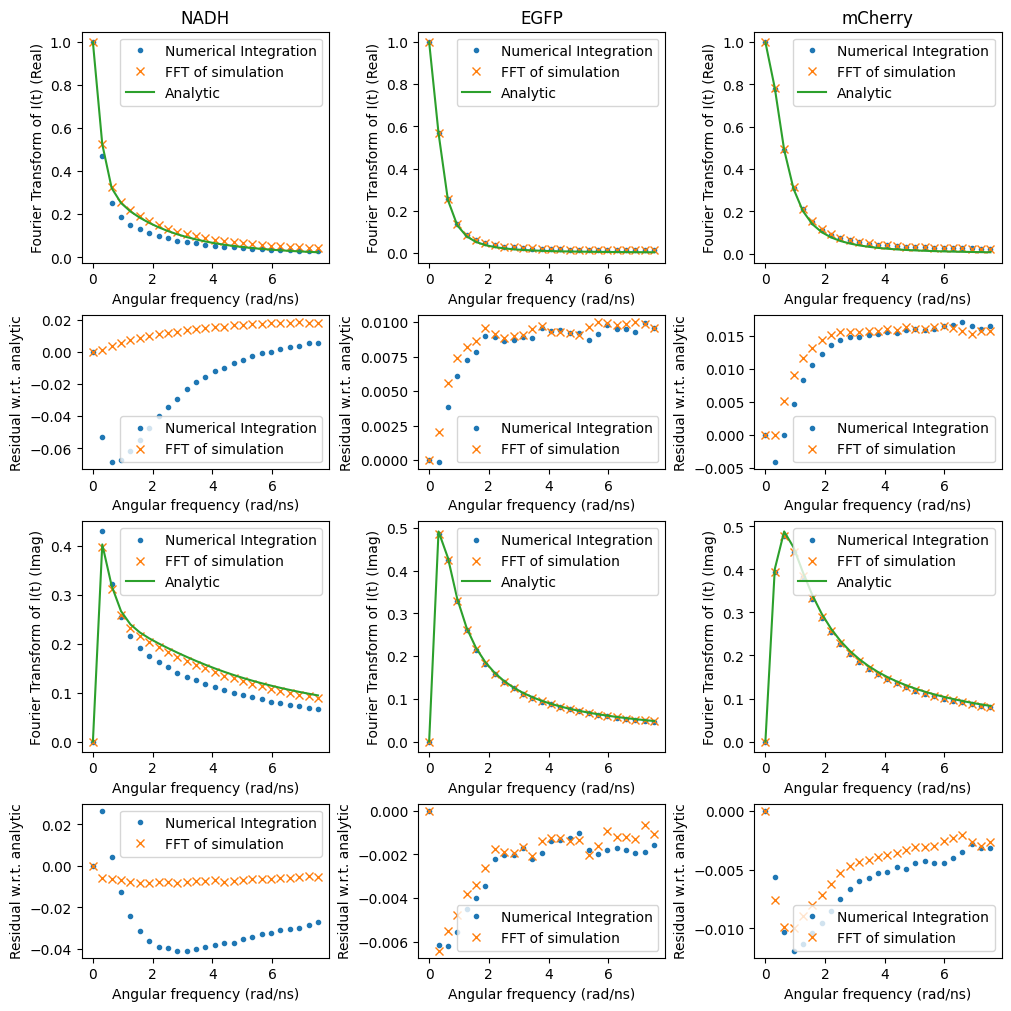

In [73]:
sim_list = [NADH,EGFP,mCherry]
sim_name = ['NADH','EGFP','mCherry']
fig,ax = plt.subplots(nrows = 4, ncols = 3,figsize = (10,10),gridspec_kw={'height_ratios': [3, 2,3,2]},constrained_layout = True)
ax = np.array(ax).flatten()
for n in range(3):
    sim = sim_list[n]
    W,Y = np.meshgrid(sim.w[:190],sim.y[15:]) 
    W,T = np.meshgrid(sim.w[:190],sim.t[:-15])
    # #W,K = np.meshgrid(sim.w[:190],sim.ker)
    # y_true= exp2(sim.t,sim.amp[0],*sim.tau)
    # #W,Y = np.meshgrid(sim.w[:190],y_true[:]) 
    # phasor = np.fft.fft(y_true)/np.sum(y_true)
    # phasor.imag*=-1
    FT = lambda Y: np.sum(np.cos(T*W)*Y+1j*np.sin(T*W)*Y,axis = 0)/np.sum(sim.y[15:]) #numerical integration for trimmed data
    phasor_true = multi_exp_FT(sim.w[:25],sim.amp,sim.tau)
    #real part
    ax[n].plot(sim.w[:25],np.real(FT(Y)[:25]),'.',label = 'Numerical Integration')
    ax[n].plot(sim.w[:25],sim.phasor.real[:25],'x',label = 'FFT of simulation')
    ax[n].plot(sim.w[:25],phasor_true.real,label = 'Analytic')
    #residual of real part
    ax[n+3].plot(sim.w[:25],np.real(FT(Y)[:25])-phasor_true.real,'.',label = 'Numerical Integration')
    ax[n+3].plot(sim.w[:25],sim.phasor.real[:25]-phasor_true.real,'x',label = 'FFT of simulation')
    #imag part
    ax[n+6].plot(sim.w[:25],np.imag(FT(Y)[:25]),'.',label = 'Numerical Integration')
    ax[n+6].plot(sim.w[:25],sim.phasor.imag[:25],'x',label = 'FFT of simulation')
    ax[n+6].plot(sim.w[:25],phasor_true.imag,label = 'Analytic')
    #residual of imag part
    ax[n+9].plot(sim.w[:25],np.imag(FT(Y)[:25])-phasor_true.imag,'.',label = 'Numerical Integration')
    ax[n+9].plot(sim.w[:25],sim.phasor.imag[:25]-phasor_true.imag,'x',label = 'FFT of simulation')


    ax[n].set_title(sim_name[n])
    ax[n].set_ylabel('Fourier Transform of I(t) (Real)')
    ax[n+3].set_ylabel('Residual w.r.t. analytic')
    ax[n+6].set_ylabel('Fourier Transform of I(t) (Imag)')
    ax[n+9].set_ylabel('Residual w.r.t. analytic')
for n in range(12):
    ax[n].set_xlabel('Angular frequency (rad/ns)')
    ax[n].legend()
plt.tight_layout
plt.savefig('fig/FT_compare.pdf',format = 'pdf')

### Decomposition of amplitudes with known lifetimes

In [4]:
EGFP = Simulation([0.503,0.497],[3.07,2.43])

With known lifetimes, fractional intensity can be solved as a system of linear eqations:
$$\begin{array}{c}
   \sum_i  f_i = 1 \\
   \sum_i  f_i/(1+(\omega_j\tau_i)^2) = g_j  \\
   \sum_i  f_i \cdot \omega_j\tau_i/(1+(\omega_j\tau_i)^2) = s_j
   \end{array}$$

- $j$ denotes the $j$ th phasor obtained from angular frequency $\omega_j$
- $i$ denotes the $i$ th component in the exponential (fractional intensity $f_i$ and lifetime $\tau_i$)
- $g$ and $s$ are the real and imaginary components of phasor respectively

if $\tau_i$ are known in advance, this is a linear system of equations

In [82]:
sim = EGFP
def f_A_solve(w,phasor,tau):
    '''This solves for fractional intensity, then convert to amplitude, with known lifetimes
       Input:
       w        angular frequency
       phasor   phasor array
       tau      lifetime array'''
    w = w[1:len(tau)]
    W,T = np.meshgrid(tau,w) 
    #only fundamental frequency is needed for 2 components
    M = np.array([[1,1],1/((W*T)**2+1)[0]]) 
    M_inv = np.linalg.inv(M)
    y = np.array([1,phasor.real[1]])
    f = np.dot(M_inv,y)
    A = NADH.A_solve(list(f)+tau) #uses the function from Phasor object,  can be applied to objects with same number of lifetime components only
    return A
for sim in sim_list:    
    print('f_A_solve:',f_A_solve(sim.w,sim.phasor,sim.tau), 'true:' ,sim.amp)

f_A_solve: [0.75242391 0.24757609] true: [0.75 0.25]
f_A_solve: [0.48466585 0.51533415] true: [0.503 0.497]
f_A_solve: [0.82993749 0.17006251] true: [0.83 0.17]


In [85]:
A_list = np.zeros((3,len(sim.phasor_data),2))
for n in range(3): 
    sim = sim_list[n]
    for i in range(len(sim.phasor_data)): #repeat sim data
        A_list[n,i] = f_A_solve(sim.w,sim.phasor_data[i],sim.tau)


In [91]:
EGFP.amp

array([0.503, 0.497])

/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_11628/404541237.py:12: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


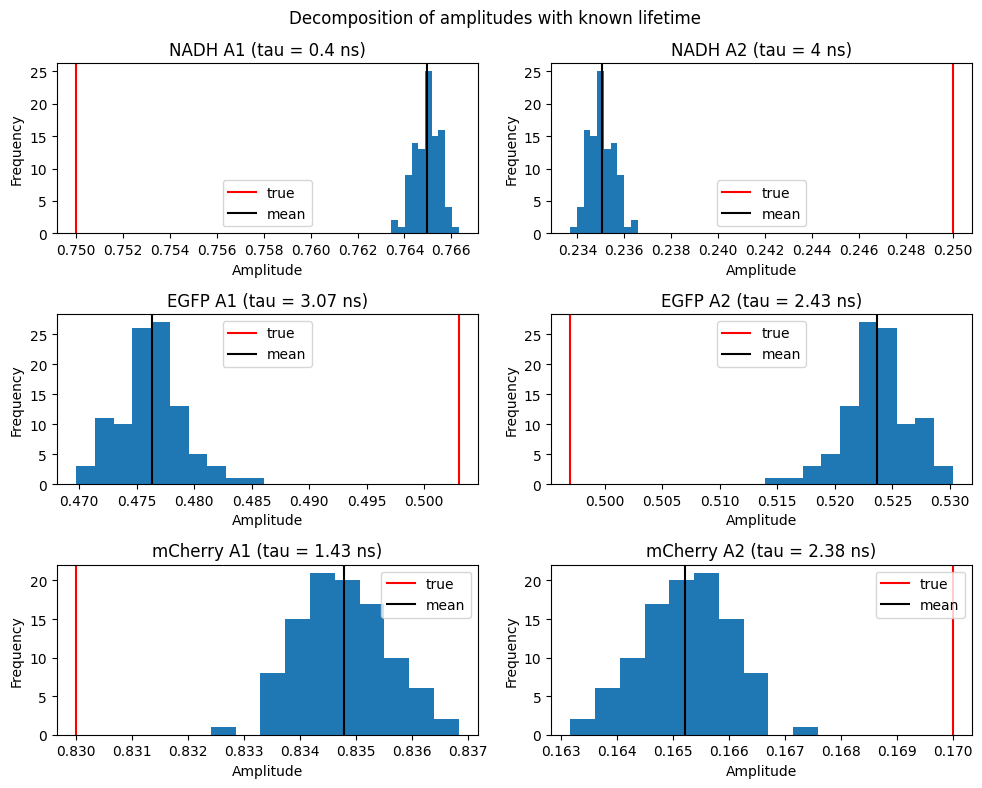

In [108]:
fig,ax = plt.subplots(nrows = 3,ncols = 2,figsize= (10,8),constrained_layout = True)
plt.suptitle('Decomposition of amplitudes with known lifetime')
for i in range(3):
    for j in range(2):
        ax[i,j].hist(A_list[i,:,j])
        ax[i,j].set_title(sim_name[i]+f' A{j+1} (tau = {sim_list[i].tau[j]} ns)')
        ax[i,j].set_xlabel('Amplitude')
        ax[i,j].set_ylabel('Frequency')
        ax[i,j].axvline(sim_list[i].amp[j],c = 'r',label = 'true')
        ax[i,j].axvline(np.mean(A_list[i,:,j]),c = 'k',label = 'mean')
        ax[i,j].legend()
plt.savefig('fig/f_A_solve.pdf',format = 'pdf')


In [39]:
def phasor_solve(w,phasor,n=2,num = False,guess=None):
    '''Solve for samplitudes and lifetimes from simulated phasor coordinates
       Input: w        angular frequency array
              phasor   output from phasor_fft
              n        number of components (Default 2)
              num      True for numerical solution, False for analytic solution
              guess    guess for numerical solution'''
    # Define the variables and symbols
    f= symbols('f1:%d' % (n+1)) #amplitudes
    t = symbols('t1:%d' % (n+1)) #lifetimes

    equations = [sum([f[j]for j in range(n)])-1]

    # Generate the equations using different angular frequencies
    for i in range(1,2*n):
        equation = sum([f[j]/ ((w[i] * t[j])**2 + 1) for j in range(n)]) - np.real(phasor)[i] #g coordinate of phasor
        equations.append(equation)
        equation = sum([f[j]*t[j]*w[i]/ ((w[i] * t[j])**2 + 1) for j in range(n)]) - np.imag(phasor)[i] #s coordinate of phasor
        equations.append(equation)

    # Solve the system of equations
    equations = equations[:2*n]
    if num == True:
        solution = nsolve(equations,[n for n in f]+[n for n in t],guess, solver='bisect')
        solution = np.concatenate(np.array(solution).astype(float)) #1d array
    else:
        solution = solve(equations)[0]
        solution = [abs(float(v)) for v in solution.values()]#convert symbols to string
    return solution

In [24]:
soln

[0.027581364787745245,
 0.9724186352122548,
 0.8217163498914972,
 2.8236602659826953]

In [29]:
phasor_true = multi_exp_FT(sim.w,sim.amp,sim.tau)

In [47]:
np.dot(EGFP.phasor-phasor_true,EGFP.phasor-phasor_true)

(0.027943039636217058+0.00011657311598876053j)

In [52]:
sim = EGFP
soln = phasor_solve(sim.w,EGFP.phasor,num=True,guess = [0.9,0.1,2.6,4.03])#list((sim.amp*sim.tau)/np.sum(sim.amp*sim.tau))+sim.tau)
Phasor.A_funcs_list(sim)
print(Phasor.A_solve(sim,soln),soln[2:])

[0.92337631 0.07662369] [2.56065045 4.61594708]


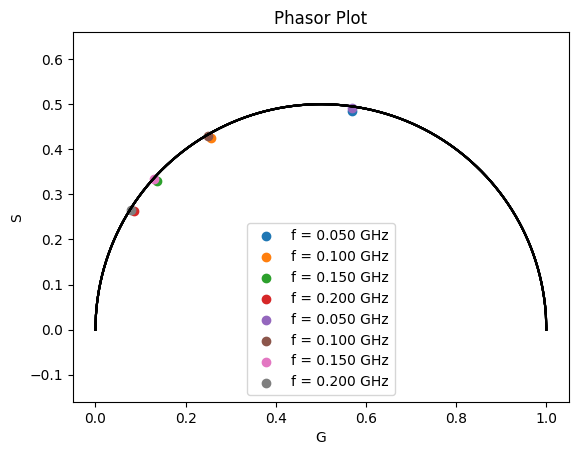

In [30]:
fig,ax = plt.subplots()
phasor_plot(ax,EGFP.w[1:5],EGFP.phasor[1:5])
phasor_plot(ax,EGFP.w[1:5],phasor_true[1:5])

### COBYLA method for more accurate decomposition

Constrained Optimization BY Linear Approximation

In [ ]:
def exp_fit(func,tdata,ydata,guess,end = int((15/20*380)),bg = 10, run_time = 20*60,weights = None,method = 'leastsq'):
    '''use least-square fit for given exponential function (exp1 or exp2)
       Inputs:
       func      exp function to be fitted 
       tdata     time array (non-trimmed)
       ydata     photon count (non-trimmed)
       guess     guess intial parameters for fitting
       end       trim the end point to avoid low count statistics
       bg        background count per s
       run_time  run_time (s)
       weights   weights for the data points of the fit (1/yerr)
       Outputs:
       result        lmfit result
       params_opt    fitted parameters
       chi2_red      reduced chi2
       fit_report    fit_report from lmfit
       '''
    model = Model(func)
    params = Parameters()
    # Get the parameter names and default values from the input function
    params_name = inspect.signature(func).parameters
    params_name = list(params_name.keys())[1:]  # Exclude 'x' from parameters
    for i,name in enumerate(params_name):
    # Add initial guess value for the parameter
        params.add(name,value=guess[i],min = 0)

    #Trim and scale data for fitting
    ydata = ydata-np.full(len(ydata),int(bg*run_time/len(tdata)))#subtract background from each bin
    max_idx = np.argmax(ydata) #index of data point with maximum photon count N(0)
    tdata = tdata[:end-max_idx] #start from t = 0
    ydata = ydata[max_idx:end]  #start from max.
    ydata = ydata/ydata[0] # scale y data such that the beginning is 1 

    
    result = model.fit(ydata, params, t=tdata,weights = weights,method = method) #perform least squares fit
    params_opt = result.params #optimized params
    chi2= result.chisqr #chi squared
    chi2_red = result.chisqr/(len(tdata)-len(params))
    fit_report = result.fit_report()
    return result, params_opt, chi2_red, fit_report

In [ ]:
for sim in [NADH,EGFP,mCherry]:
    sim.multi_exp_data()
    y_noiseless = exp2(sim.t,sim.amp[0],*sim.tau)
    y_noise = sim.y2
    weights = np.sqrt(sim.y)[np.argmax(y_noise):int((15/20*380))]
    result, params_opt, chi2_red, fit_report = exp_fit(exp2,sim.t,y_noise,[sim.amp[0]]+sim.tau
    ,weights = weights,method = 'cobyla') #use fitting method 'cobyla'
    print(fit_report)

[[Model]]
    Model(exp2)
[[Fit Statistics]]
    # fitting method   = COBYLA
    # function evals   = 49
    # data points      = 275
    # variables        = 3
    chi-square         = 4.55782000
    reduced chi-square = 0.01675669
    Akaike info crit   = -1121.47983
    Bayesian info crit = -1110.62952
[[Variables]]
    A1:    0.75010077 +/- 5.4347e-04 (0.07%) (init = 0.75)
    tau1:  0.39763206 +/- 4.5858e-04 (0.12%) (init = 0.4)
    tau2:  3.99820758 +/- 0.01170211 (0.29%) (init = 4)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, tau2)   = 0.897
    C(A1, tau1)   = 0.863
    C(tau1, tau2) = 0.706
[[Model]]
    Model(exp2)
[[Fit Statistics]]
    # fitting method   = COBYLA
    # function evals   = 70
    # data points      = 275
    # variables        = 3
    chi-square         = 21.9294802
    reduced chi-square = 0.08062309
    Akaike info crit   = -689.458290
    Bayesian info crit = -678.607977
[[Variables]]
    A1:    0.50231824 +/- 0.14769553 (29.40%) (init 

In [ ]:
sim = EGFP
results = [] #list to store ModelResult objects
for i in range(100):
    sim.multi_exp_data()
    y_noiseless = exp2(sim.t,sim.amp[0],*sim.tau)
    y_noise = sim.y2
    weights = np.sqrt(sim.y2)[np.argmax(sim.y2):int((15/20*380))]
    result, params_opt, chi2_red, fit_report = exp_fit(exp2,sim.t,y_noise,[sim.amp[0]]+sim.tau
    ,weights = weights,method = 'cobyla') #use fitting method 'cobyla'
    print(fit_report)
    results.append(result)

In [ ]:
info_df, par_df = fit_df(results) #create fit and parameter datafame using results list

In [107]:
NADH.info_df

,chisqr,redchi,_val,init_value,stderr,correl
0,6.271532,0.023057,"[0.75, 0.406, 4.01]","[0.75, 0.4, 4]","[0.000639, 0.000541, 0.0138]","[{'tau1': '0.863', 'tau2': '0.896'}, {'A1': '0..."
1,4.599273,0.016909,"[0.751, 0.402, 4.02]","[0.75, 0.4, 4]","[0.000544, 0.000459, 0.0118]","[{'tau1': '0.863', 'tau2': '0.895'}, {'A1': '0..."
2,5.285444,0.019432,"[0.75, 0.399, 4]","[0.75, 0.4, 4]","[0.000587, 0.000493, 0.0127]","[{'tau1': '0.864', 'tau2': '0.897'}, {'A1': '0..."
3,5.326808,0.019584,"[0.75, 0.401, 4]","[0.75, 0.4, 4]","[0.000592, 0.000497, 0.0128]","[{'tau1': '0.865', 'tau2': '0.898'}, {'A1': '0..."
4,9.884173,0.036339,"[0.751, 0.4, 4]","[0.75, 0.4, 4]","[0.000802, 0.000673, 0.0173]","[{'tau1': '0.864', 'tau2': '0.897'}, {'A1': '0..."
...,...,...,...,...,...,...
95,8.898133,0.032714,"[0.75, 0.402, 4.02]","[0.75, 0.4, 4]","[0.000759, 0.00064, 0.0164]","[{'tau1': '0.864', 'tau2': '0.896'}, {'A1': '0..."
96,5.006991,0.018408,"[0.75, 0.401, 4]","[0.75, 0.4, 4]","[0.00057, 0.00048, 0.0123]","[{'tau1': '0.864', 'tau2': '0.896'}, {'A1': '0..."
97,6.832312,0.025119,"[0.749, 0.397, 4]","[0.75, 0.4, 4]","[0.000673, 0.000563, 0.0145]","[{'tau1': '0.867', 'tau2': '0.899'}, {'A1': '0..."
98,5.896135,0.021677,"[0.75, 0.396, 4]","[0.75, 0.4, 4]","[0.000617, 0.000517, 0.0133]","[{'tau1': '0.864', 'tau2': '0.897'}, {'A1': '0..."


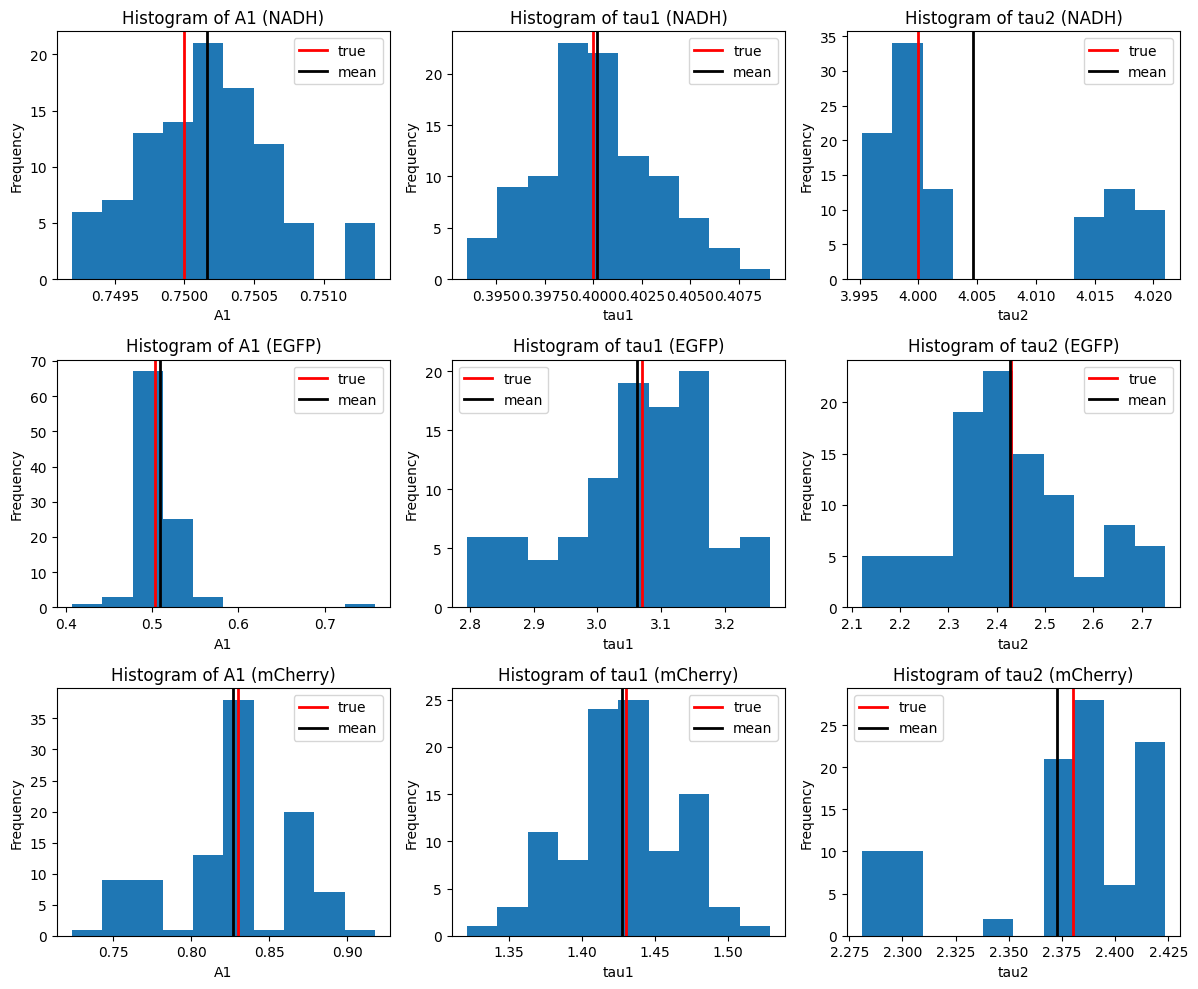

<Figure size 640x480 with 0 Axes>

In [104]:

# Create subplots with the desired number of rows and columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
axes = np.array(axes).flatten()
# Iterate over each column in the DataFrame
for n in range(3):
    sim = [NADH,EGFP,mCherry][n]
    name = ['NADH','EGFP','mCherry'][n]
    true_list = [sim.amp[0]]+sim.tau
    for idx, column in enumerate(sim.val_df):
        i = idx+3*n #index of the subplot
        # Plot the histogram on the corresponding axis
        axes[i].hist(sim.val_df[column], bins=10)  # Adjust the number of bins as needed
        axes[i].axvline(true_list[idx].real,lw = 2,c = 'r',label = 'true')
        axes[i].axvline(np.mean(sim.val_df[column]),lw = 2,c = 'k',label = 'mean')
        # Set the title and labels for the plot
        axes[i].set_title(f"Histogram of {column} ({name})")
        axes[i].set_xlabel(column)

    
        axes[i].set_ylabel("Frequency")
        axes[i].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()
plt.savefig('fig/COBYLA_fit.pdf',format = 'pdf')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


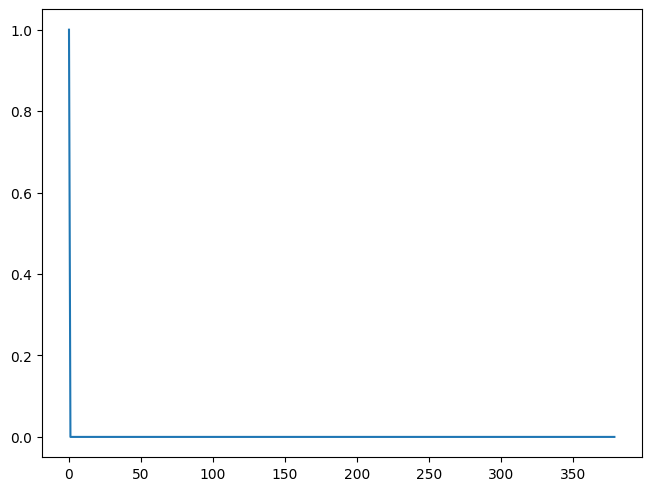

In [55]:
bg = np.ones(380)*EGFP.bg*EGFP.run_time/EGFP.n_bins
plt.plot(np.fft.fft(bg)/np.sum(bg))